# **Launch Sites Locations Analysis with Folium**


Estimated time needed: **40** minutes


The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.


In the previous exploratory data analysis labs, you have visualized the SpaceX launch dataset using `matplotlib` and `seaborn` and discovered some preliminary correlations between the launch site and success rates. In this lab, you will be performing more interactive visual analytics using `Folium`.


## Objectives


This lab contains the following tasks:

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.


Let's first import required Python packages for this lab:


In [1]:
!pip3 install folium
!pip3 install wget

You should consider upgrading via the '/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
!pip install folium==0.7.0

     |████████████████████████████████| 85 kB 167 kB/s eta 0:00:01
  Attempting uninstall: folium
    Found existing installation: folium 0.5.0
    Uninstalling folium-0.5.0:
      Successfully uninstalled folium-0.5.0
You should consider upgrading via the '/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/bin/python3.9 -m pip install --upgrade pip' command.


In [9]:
import folium
import wget
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

If you need to refresh your memory about folium, you may download and refer to this previous folium lab:


[Generating Maps with Python](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module\_3/DV0101EN-3-5-1-Generating-Maps-in-Python-py-v2.0.ipynb)


## Task 1: Mark all launch sites on a map


First, let's try to add each site's location on a map using site's latitude and longitude coordinates


The following dataset with the name `spacex_launch_geo.csv` is an augmented dataset with latitude and longitude added for each site.


In [3]:
# Download and read the `spacex_launch_geo.csv`
spacex_df=pd.read_csv('dataset_part_2.csv')
spacex_df.head()

index  FlightNumber        Date BoosterVersion  PayloadMass Orbit  \
0      4             1  2010-06-04       Falcon 9  8048.292606   LEO   
1      5             2  2012-05-22       Falcon 9   525.000000   LEO   
2      6             3  2013-03-01       Falcon 9   677.000000   ISS   
3      7             4  2013-09-29       Falcon 9   500.000000    PO   
4      8             5  2013-12-03       Falcon 9  3170.000000   GTO   

     LaunchSite      Outcome  Flights  GridFins  Reused   Legs LandingPad  \
0  CCSFS SLC 40    None None        1     False   False  False        NaN   
1  CCSFS SLC 40    None None        1     False   False  False        NaN   
2  CCSFS SLC 40    None None        1     False   False  False        NaN   
3   VAFB SLC 4E  False Ocean        1     False   False  False        NaN   
4  CCSFS SLC 40    None None        1     False   False  False        NaN   

   Block  ReusedCount Serial   Longitude   Latitude  Class  
0    1.0            0  B0003  -80.577366  28.561857      0  
1    1.0            0  B0005  -80.577366  28.561857      0  
2    1.0            0  B0007  -80.577366  28.561857      0  
3    1.0            0  B1003 -120.610829  34.632093      0  
4    1.0            0  B1004  -80.577366  28.561857      0

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/matplotlib/bezier.py:216: RuntimeWarning: divide by zero encountered in power
  return (np.power.outer(1 - t, self._orders[::-1])
/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/matplotlib/bezier.py:217: RuntimeWarning: divide by zero encountered in power
  * np.power.outer(t, self._orders)) @ self._px


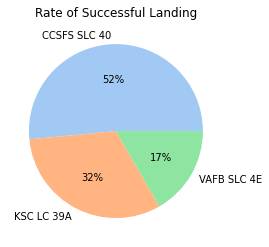

In [10]:
LaunchSite_success = spacex_df.loc[spacex_df['Class']==1]
df_success = LaunchSite_success.groupby(['LaunchSite'])['LaunchSite'].count()

colors = sns.color_palette('pastel')[0:7]
plt.pie(df_success, labels = df_success.index, colors = colors, autopct='%.0f%%')
plt.title("Rate of Successful Landing" )
plt.show()

Now, you can take a look at what are the coordinates for each site.


In [4]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['LaunchSite', 'Latitude', 'Longitude', 'Class']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]
launch_sites_df

LaunchSite   Latitude   Longitude
0  CCSFS SLC 40  28.561857  -80.577366
1    KSC LC 39A  28.608058  -80.603956
2   VAFB SLC 4E  34.632093 -120.610829

Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.


We first need to create a folium `Map` object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.


In [5]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use `folium.Circle` to add a highlighted circle area with a text label on a specific coordinate. For example,


In [6]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

and you should find a small yellow circle near the city of Houston and you can zoom-in to see a larger circle.


Now, let's add a circle for each launch site in data frame `launch_sites`


*TODO:*  Create and add `folium.Circle` and `folium.Marker` for each launch site on the site map


An example of folium.Circle:


`folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(...))`


An example of folium.Marker:


`folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'label', ))`


In [7]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for lat, lng, label, in zip(spacex_df.Latitude, spacex_df.Longitude, spacex_df.LaunchSite):
    #circle
    folium.Circle([lat, lng], radius=1000, color='#000000', fill=True).add_child(folium.Popup(label)).add_to(site_map)
    #marker
    folium.map.Marker([lat, lng], icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' %label, )).add_to(site_map)
    
# display map
site_map

The generated map with marked launch sites should look similar to the following:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_markers.png" />
</center>


Now, you can explore the map by zoom-in/out the marked areas
, and try to answer the following questions:

*   Are all launch sites in proximity to the Equator line?
*   Are all launch sites in very close proximity to the coast?

Yes, they are :


If a spacecraft is launched from a site near Earth's equator, it can take optimum advantage of the Earth's substantial rotational speed. Sitting on the launch pad near the equator, it is already moving at a speed of over 1650 km per hour relative to Earth's center.

All  launch site are very close to the coast because Since the Earth rotates eastward, not only would the object being launched get a nice boost from the Earth's spin, the object would have the advantage of flying over the ocean, minimizing the risk of having any debris dropping or exploding near people.

# Task 2: Mark the success/failed launches for each site on the map


Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates.
Recall that data frame spacex_df has detailed launch records, and the `class` column indicates if this launch was successful or not


In [8]:
spacex_df.tail(10)

LaunchSite   Latitude   Longitude  Class
153  CCSFS SLC 40  28.561857  -80.577366      1
154   VAFB SLC 4E  34.632093 -120.610829      1
155    KSC LC 39A  28.608058  -80.603956      1
156  CCSFS SLC 40  28.561857  -80.577366      1
157   VAFB SLC 4E  34.632093 -120.610829      1
158  CCSFS SLC 40  28.561857  -80.577366      1
159  CCSFS SLC 40  28.561857  -80.577366      1
160    KSC LC 39A  28.608058  -80.603956      1
161   VAFB SLC 4E  34.632093 -120.610829      1
162  CCSFS SLC 40  28.561857  -80.577366      1

Next, let's create markers for all launch records.
If a launch was successful `(class=1)`, then we use a green marker and if a launch was failed, we use a red marker `(class=0)`


Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.


Let's first create a `MarkerCluster` object


In [9]:
marker_cluster = MarkerCluster()


*TODO:* Create a new column in `launch_sites` dataframe called `marker_color` to store the marker colors based on the `class` value


In [ ]:

# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red


In [10]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['Class'].apply(assign_marker_color)
spacex_df.tail(10)

LaunchSite   Latitude   Longitude  Class marker_color
153  CCSFS SLC 40  28.561857  -80.577366      1        green
154   VAFB SLC 4E  34.632093 -120.610829      1        green
155    KSC LC 39A  28.608058  -80.603956      1        green
156  CCSFS SLC 40  28.561857  -80.577366      1        green
157   VAFB SLC 4E  34.632093 -120.610829      1        green
158  CCSFS SLC 40  28.561857  -80.577366      1        green
159  CCSFS SLC 40  28.561857  -80.577366      1        green
160    KSC LC 39A  28.608058  -80.603956      1        green
161   VAFB SLC 4E  34.632093 -120.610829      1        green
162  CCSFS SLC 40  28.561857  -80.577366      1        green

*TODO:* For each launch result in `spacex_df` data frame, add a `folium.Marker` to `marker_cluster`


In [12]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for index, record in spacex_df.iterrows():
    # TODO: Create and add a Marker cluster to the site map
    marker = folium.Marker([record['Latitude'],record['Longitude']],icon=folium.Icon(color='white',icon_color=record['marker_color']))
    marker_cluster.add_child(marker)

site_map


Your updated map may look like the following screenshots:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_cluster.png" />
</center>


# TASK 3: Calculate the distances between a launch site to its proximities


Next, we need to explore and analyze the proximities of launch sites.


Let's first add a `MousePosition` on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)


In [13]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

Now zoom in to a launch site and explore its proximity to see if you can easily find any railway, highway, coastline, etc. Move your mouse to these points and mark down their coordinates (shown on the top-left) in order to the distance to the launch site.


You can calculate the distance between two points on the map based on their `Lat` and `Long` values using the following method:


In [14]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

*TODO:* Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.


In [ ]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

*TODO:* After obtained its coordinate, create a `folium.Marker` to show the distance


*TODO:* Draw a `PolyLine` between a launch site to the selected coastline point


In [ ]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
# lines=folium.PolyLine(locations=coordinates, weight=1)

Your updated map with distance line should look like the following screenshot:


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_3/images/launch_site_marker_distance.png" />
</center>


*TODO:* Similarly, you can draw a line betwee a launch site to its closest city, highway, etc. You need to use `MousePosition` to find the their coordinates on the map first


In [15]:
#Work out distance to coastline
coordinates = [
    [28.56342, -80.57674],
    [28.56342, -80.56756]]

lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)
distance = calculate_distance(coordinates[0][0], coordinates[0][1], coordinates[1][0], coordinates[1][1])
distance_circle = folium.Marker(
    [28.56342, -80.56794],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
        )
    )
site_map.add_child(distance_circle)
site_map


In [17]:

#Distance to Highway
coordinates = [
    [28.56342, -80.57674],
    [28.411780, -80.820630]]

lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)
distance = calculate_distance(coordinates[0][0], coordinates[0][1], coordinates[1][0], coordinates[1][1])
distance_circle = folium.Marker(
    [28.411780, -80.820630],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#252526;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
        )
    )
site_map.add_child(distance_circle)
site_map



In [18]:
#Distance to Florida City 

coordinates = [
    [28.56342, -80.57674],
    [28.5383, -81.3792]]

lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)
distance = calculate_distance(coordinates[0][0], coordinates[0][1], coordinates[1][0], coordinates[1][1])
distance_circle = folium.Marker(
    [28.5383, -81.3792],
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#252526;"><b>%s</b></div>' % "{:10.2f} KM".format(distance),
        )
    )
site_map.add_child(distance_circle)
site_map

After you plot distance lines to the proximities, you can answer the following questions easily:

*   Are launch sites in close proximity to highways? No
*   Are launch sites in close proximity to coastline? No
*   Do launch sites keep certain distance away from cities? Yes 

Also please try to explain your findings.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01)


### Other Contributors


Joseph Santarcangelo


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |
| ----------------- | ------- | ---------- | --------------------------- |
| 2021-05-26        | 1.0     | Yan        | Created the initial version |


Copyright © 2021 IBM Corporation. All rights reserved.
